### Select Object

In [172]:
object_tar = "a Coca-Cola can"

### Object labeling

In [173]:
object_dict = ["a Red Bull can", 
                "a Pringles can", 
                "a Coca-Cola can", 
                "an orange", 
                "an apple"]

### Import Library

In [174]:
import json
import matplotlib.pyplot as plt
import numpy as np
import mujoco
import mujoco_viewer
import cv2,os
import sys
import colorsys
import time
sys.path.append('../')
""" FOR MuJoCo """
from models.utils.util import  *
from models.env.manipulator_agent import ManipulatorAgent
""" INTERPOLATION """
from interpolation_tools import *

### Initialize Mujoco

In [175]:
xml_path = '../asset/ur5e/object_scene.xml'
MODE = 'window' ################### 'window' or 'offscreen'
env = ManipulatorAgent(rel_xml_path=xml_path,VERBOSE=False, MODE=MODE)

print(env.ctrl_names)
print(env.idxs_step)
# Initail pose
init_joint_value = [-0.7330382, -2.26892803,  1.81514242,  1.57079633, 1.23918377, -0.50614548]
env.forward(q=init_joint_value, joint_idxs=env.idxs_forward)
render_dt = 1./30.
env.close_viewer()
print ("Ready.")

MODE: window
['shoulder_pan', 'shoulder_lift', 'elbow', 'wrist_1', 'wrist_2', 'wrist_3', 'gripper']
[0, 1, 2, 3, 4, 5]
Ready.


### Gripper Control Function

In [176]:
def step_gripper(env:ManipulatorAgent, command:str="", nstep:int=1):
    if command.lower() == "open":
        env.step(ctrl=[1.25],ctrl_idxs=[6],nstep=nstep)
    elif command.lower() == "close":
        env.step(ctrl=[0],ctrl_idxs=[6],nstep=nstep)
    else:
        env.step()

### Render PCD?

In [177]:
#RENDER_PCD = True
RENDER_PCD = False

### Get projection of pcd for xy plane 

MODE: window


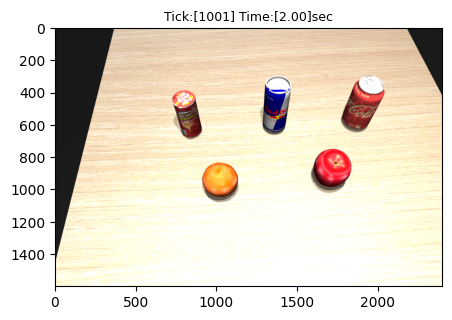

In [178]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=3.5,elevation=-40,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=init_joint_value, joint_idxs=env.idxs_forward)
render_dt = 1./30.
p_time = env.get_p_body('ur_base')
p_time[2] += 0.5
t_s = time.perf_counter()
t_sim_start = t_s
while env.is_viewer_alive():

    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        env.step(ctrl=init_joint_value, ctrl_idxs=env.idxs_step)
        step_gripper(env,command="open")
        
    if time.perf_counter() - t_s >= render_dt:
        t_s += render_dt
        env.plot_T(p=env.get_p_body('ur_base'),R=env.get_R_body('ur_base'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.plot_T(p=p_time,R=env.get_R_body('ur_base'),label="simtime=[%.1f],realtime=[%.1f]"%(env.get_sim_time(),time.perf_counter()-t_sim_start),PLOT_AXIS=False)
        env.plot_T(p=env.get_p_body('ur_camera_center'),R=env.get_R_body('ur_camera_center'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.plot_T(p=env.get_p_body('ur_tcp_link'),R=env.get_R_body('ur_tcp_link'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)

        if RENDER_PCD:
            p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
            p_ego  = p_cam
            p_trgt = p_cam + R_cam[:,2]
            rgb_img,depth_img,pcd,xyz_img,xyz_img_world = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=10,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
            filterd_by_z = pcd[pcd[:, 2] > 0.05]
            table_z = np.min(filterd_by_z, axis=0)[2]
            for i,p in enumerate(pcd):
                if p[2] > table_z+0.03:
                    env.plot_sphere(p=p,r=0.005,rgba=np.array([0, 1, 0, 1]))
        env.render()
    if env.get_sim_time() > 2:
        p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img,xyz_img_world = env.get_egocentric_rgb_depth_pcd(
        p_ego=p_ego,p_trgt=p_trgt,rsz_rate=1,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        # z threashold filter
        filterd_by_z = pcd[pcd[:, 2] > 0.05]
        table_z = np.min(filterd_by_z, axis=0)[2]
        filterd_by_z = pcd[pcd[:, 2] > table_z+0.05] 
        env.render()
        break
# Plot the final scene and egocentric images
plt.figure(figsize=(5,4)); plt.imshow(rgb_img)
plt.imsave('../image/output.png', rgb_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
plt.close()
env.close_viewer()


### OwlVit v2 detection

In [179]:
import sys
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

current_dir = os.getcwd()
# Navigate up one directory to get the correct path
sys.path.insert(0, os.path.abspath(os.path.join(current_dir, "..","..", "src")))

from detection_module.owlv2 import Owlv2
from detection_module.utils import calculate_iou, show_images

### Load Image

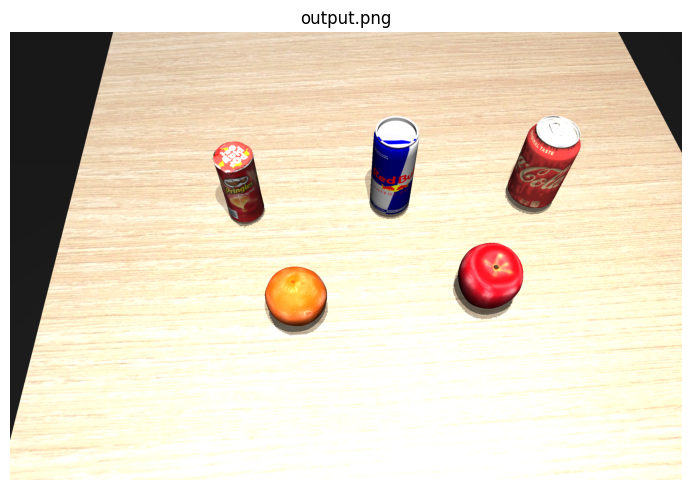

In [180]:
image_dir = "../image"
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
image_paths = sorted(image_paths)
images = [Image.open(img).convert("RGB") for img in image_paths]
titles = [os.path.basename(img_path) for img_path in image_paths]

# Show images using the utility function
show_images(images, titles)

### Forward Model

a Coca-Cola can [1776  295 2040  639]
a Red Bull can [1258  299 1432  659]
a Pringles can [725 387 909 682]
an apple [1605  750 1837  989]
an orange [ 914  836 1133 1049]


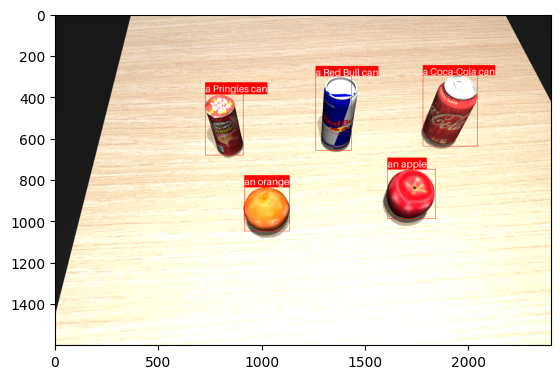

In [181]:
sample = {
        'image': images[0],
        'text': object_dict,
    }
# load model 
owlvit = Owlv2()
sample['box_threshold'] = 0.3
result = owlvit.detect_objects(**sample)[0]
img = sample['image']
boxes = result['boxes']
labels = [sample['text'][idx] for idx in result['labels'].tolist()]
boxes_list = np.array(result['boxes'].tolist())
boxes_list = boxes_list.astype(int)
for label,box in zip(labels,boxes_list):
    print(label,box)
img_boxed = owlvit.draw_boxes(img, boxes, labels)
plt.imshow(img)
img.save("../detection_result.png")

### Projection

In [182]:
# Crop pcd
for label,box in zip(labels,boxes_list):
    if label == object_tar:
        x_min = box[0]
        y_min = box[1]
        x_max = box[2]
        y_max = box[3]
        break

h,w = depth_img.shape
pcd_xy = pcd.reshape(h,w,3)
pcd_crop = pcd_xy[y_min:y_max, x_min:x_max]
pcd_crop = pcd_crop.reshape(-1, 3)
pcd_crop = pcd_crop[pcd_crop[:,2] > (table_z+0.03)]

# make Projection
proj = np.ones((400, 400, 3), dtype=np.uint8) * 255
for p in pcd_crop:
    xy = [0,0]
    xy[0] = int((p[0] - 0.5) / 0.6 * 400)
    xy[1] = int((p[1] + 0.3) / 0.6 * 400)
    cv2.circle(proj, (xy[0],xy[1]), 5, (0, 0, 0), -1)
cv2.imwrite('../before_transformation.png', proj)
print ("Ready.")
proj_img = plt.imread('../before_transformation.png')

Ready.


### Circle detection by Hough Transform

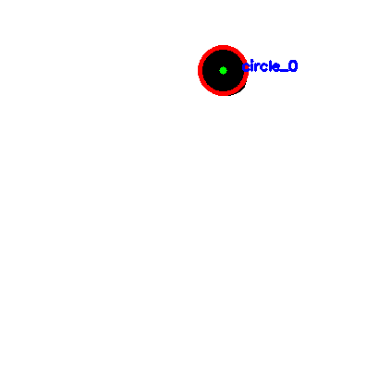

In [183]:
src = cv2.imread("../before_transformation.png")
dst = src.copy()
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1 = 250, param2 = 10, minRadius = 16, maxRadius = 30)
circles = np.uint16(np.around(circles))
circles = circles.reshape(-1,3)
sorted_idx = np.argsort(circles[:,1])
circles = circles[sorted_idx]
if len(circles) >1:
    print("Too many circles detected")
else:
    for idx,i in enumerate(circles):
        cv2.circle(dst, (i[0], i[1]), 4, (0, 255, 0), -1)
        cv2.circle(dst,(i[0], i[1]), i[2], (0, 0, 255), 3)
        cv2.putText(dst,'circle_{}'.format(idx),(i[0]+20, i[1]),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2)
    cv2.imwrite("../after_transformation.png", dst)
    cv2.imshow("img", dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img = plt.imread("../after_transformation.png")
    plt.axis('off')
    plt.imshow(img)



### Find grasp positon

In [184]:
img = plt.imread("../before_transformation.png")
h,w = img.shape[0:2]
grasp_pixel = (circles[0][0],circles[0][1])
grasp_x = 0.6 + 0.6 * grasp_pixel[0] / w 
grasp_y = -0.3 + 0.6 * grasp_pixel[1] / h

# nearest point search
nearest_point_idx = np.argmin(np.linalg.norm(pcd_crop[:,0:2] - np.array([[grasp_x, grasp_y]]*len(pcd_crop)), axis=1))
print("Obejct : ",pcd_crop[nearest_point_idx])
grasping_point = pcd_crop[nearest_point_idx].copy()
grasping_point[0] -= 0.02 #magic number
if object_tar in ['an orange','an apple']:    
    grasping_point[2] -= 0.02 #magic number
else:
    grasping_point[2] = np.average([grasping_point[2],table_z])
print("Grasping point: ",grasping_point)

Obejct :  [ 0.87647342 -0.19733118  0.86683173]
Grasping point:  [ 0.85647342 -0.19733118  0.80345487]


### Render grasp point

MODE: window
Ready.


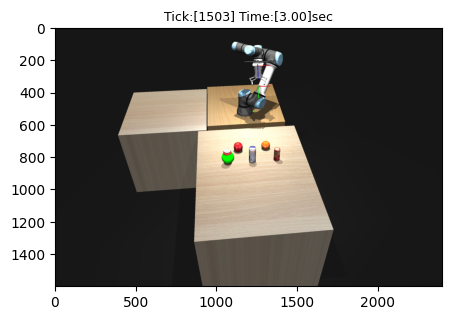

In [185]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=3.5,elevation=-40,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=init_joint_value, joint_idxs=env.idxs_forward)
render_dt = 1./30.
p_time = env.get_p_body('ur_base')
p_time[2] += 0.5
t_s = time.perf_counter()
t_sim_start = t_s
while env.is_viewer_alive():
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        env.step(ctrl=init_joint_value, ctrl_idxs=env.idxs_step)
        step_gripper(env,command="open")
    if time.perf_counter() - t_s >= render_dt:
        t_s += render_dt
        env.plot_T(p=env.get_p_body('ur_base'),R=env.get_R_body('ur_base'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.plot_T(p=p_time,R=env.get_R_body('ur_base'),label="simtime=[%.1f],realtime=[%.1f]"%(env.get_sim_time(),time.perf_counter()-t_sim_start),PLOT_AXIS=False)
        env.plot_T(p=env.get_p_body('ur_camera_center'),R=env.get_R_body('ur_camera_center'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.plot_sphere(p=grasping_point, r=0.05, rgba=np.array([0, 1, 0, 1]))
        env.plot_T(p=env.get_p_body('ur_tcp_link'),R=env.get_R_body('ur_tcp_link'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.render()
    if env.get_sim_time() > 3:
        img = env.grab_image()
        break
    
env.close_viewer()
print ("Ready.")
# Plot the final scene and egocentric images
plt.figure(figsize=(5,4)); plt.imshow(img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
plt.close()

### Solve IK (grasping)

In [186]:

xml_path_fw = '../asset/ur5e/realworld.xml'
env_fw = ManipulatorAgent(rel_xml_path=xml_path_fw,VERBOSE=False, MODE=MODE)
env_fw.reset()
env_fw.forward(q=init_joint_value, joint_idxs=env.idxs_forward)

if object_tar in ['an orange', 'an apple']:
    R_trgt = rpy2r(np.radians([-90, 0, 90])) # Rotation fixed
else:
    R_trgt = rpy2r(np.radians([-180, 0, 90])) # Rotation fixed

q_init = np.array(init_joint_value)
q_setup = np.array([-0.00506145, -2.04203522,  2.07694181, -0.06283185,  1.58824962,  0.03490659])
q_traj = []
q_traj.append(q_init)
q_traj.append(q_setup)
p_grasp = grasping_point
p_pregrasp = p_grasp + np.array([0,0,0.2])
p_anchor = []
p_anchor.append(p_pregrasp)
p_anchor.append(p_grasp)
for i in range(len(p_anchor)):
    q_point, ik_done = env_fw.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_anchor[i],R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_traj[i+1],idxs_forward=env_fw.idxs_forward, idxs_jacobian=env_fw.idxs_jacobian,
        RESET=False,DO_RENDER=False,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=10000)
    q_traj.append(q_point)
    if ik_done == False:
        print("IK does not solved.")

print("IK solved.")



MODE: window
IK solved.


### Solve IK (placing)

In [187]:
q_init_pl = q_traj[-1].copy()
p_place = np.array([p_grasp[1],-p_grasp[0],p_grasp[2]])
p_place[0] = p_grasp[1]
p_place[1] = -p_grasp[0]
p_place[2] = p_grasp[2]
p_preplace =  p_place.copy() + np.array([0, 0, 0.1])
q_traj_pl = []
q_traj_pl.append(q_init_pl)

q_prepreplace = q_traj[-2].copy()
q_traj_pl.append(q_prepreplace)
q_preplace = q_prepreplace.copy()
q_preplace[0] = q_prepreplace[0] + d2r(-90)
q_traj_pl.append(q_preplace)

env.forward(q=q_preplace, joint_idxs=env.idxs_forward)
R_trgt_pl = env.get_R_body('ur_tcp_link')


q_place, ik_done = env_fw.solve_ik_repel(
    body_name='ur_tcp_link',p_trgt=p_place,R_trgt=R_trgt_pl,
    IK_P=True,IK_R=True, q_init=q_preplace,idxs_forward=env_fw.idxs_forward, idxs_jacobian=env_fw.idxs_jacobian,
    RESET=False,DO_RENDER=False,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=10000)
q_traj_pl.append(q_place)
if ik_done == False:
    print("IK does not solved.")
else:
    print("IK solved.")

IK solved.


### Check IK Result

In [188]:

env_fw.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env_fw.update_viewer(azimuth=174.08,distance=3.5,elevation=-40,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env_fw.reset()
env_fw.forward(q=init_joint_value, joint_idxs=env_fw.idxs_forward)
tick = 0
while env_fw.is_viewer_alive():
    if tick < len(q_traj):
        env_fw.forward(q=q_traj[tick], joint_idxs=env_fw.idxs_forward)
        env_fw.plot_T(p=env_fw.get_p_body('ur_base'),R=env_fw.get_R_body('ur_base'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        for i in p_anchor:
            env_fw.plot_sphere(p=i, r=0.005, rgba=[0, 1, 0, 1])
        env_fw.plot_sphere(p=grasping_point, r=0.03, rgba=np.array([1, 0, 0, 1]))
        env_fw.plot_sphere(p=p_place, r=0.03, rgba=np.array([1, 0, 0, 1]))
        env_fw.render()
        time.sleep(0.5)
        tick += 1   
    else:
        env_fw.forward(q=q_traj_pl[tick-len(q_traj)], joint_idxs=env_fw.idxs_forward)
        env_fw.plot_T(p=env_fw.get_p_body('ur_base'),R=env_fw.get_R_body('ur_base'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env_fw.plot_sphere(p=grasping_point, r=0.03, rgba=np.array([1, 0, 0, 1]))
        env_fw.plot_sphere(p=p_place, r=0.03, rgba=np.array([1, 0, 0, 1]))
        env_fw.render()
        time.sleep(0.5)
        tick += 1
        if tick >= len(q_traj_pl)+len(q_traj):
            break
env_fw.close_viewer()

MODE: window


### Interplation & Smoothing (grasping)

In [189]:
""" Set params"""
HZ = 50
dt = 1./HZ 
t_i = 2. # Time increasing rate when the optimization failed.

q_anchors = np.array(q_traj)
N,D = q_anchors.shape
print(N,D)
q_lowers = d2r([-360.]*D)
q_uppers = d2r([360.]*D)

vel_limit = d2r(120.)
acc_limit = d2r(60.)
jerk_limit = d2r(180.)


""" Interpolate and smooth """

times, traj_interp, traj_smt, times_anchor = interpolate_and_smooth_nd(
    anchor      = q_anchors,
    time_increasing_rate = t_i,
    HZ          = HZ,
    vel_init    = 0.0, 
    vel_final   = 0.0, 
    x_lowers    = q_lowers,
    x_uppers    = q_uppers,
    vel_limit   = vel_limit,
    acc_limit   = acc_limit,
    jerk_limit  = jerk_limit,
    verbose     = True,
)


4 6
Try smoothing for 1.0 seconds...
Optimization failed at 1.0 seconds.
Try smoothing for 3.0 seconds...
Optimization failed at 3.0 seconds.
Try smoothing for 5.0 seconds...
Optimization failed at 5.0 seconds.
Try smoothing for 7.0 seconds...
Optimization is successful at 7.0 seconds.


### Interplation & Smoothing (placing)

In [190]:
""" Set params"""
HZ = 50
dt = 1./HZ 
t_i = 2. # Time increasing rate when the optimization failed.

q_anchors_pl = np.array(q_traj_pl)
N,D = q_anchors_pl.shape
print(N,D)
q_lowers = d2r([-360.]*D)
q_uppers = d2r([360.]*D)

vel_limit = d2r(120.)
acc_limit = d2r(60.)
jerk_limit = d2r(180.)


""" Interpolate and smooth """

times_pl, traj_interp_pl, traj_smt_pl, times_anchor_pl = interpolate_and_smooth_nd(
    anchor      = q_anchors_pl,
    time_increasing_rate = t_i,
    HZ          = HZ,
    vel_init    = 0.0, 
    vel_final   = 0.0, 
    x_lowers    = q_lowers,
    x_uppers    = q_uppers,
    vel_limit   = vel_limit,
    acc_limit   = acc_limit,
    jerk_limit  = jerk_limit,
    verbose     = True,
)

4 6
Try smoothing for 1.0 seconds...
Optimization failed at 1.0 seconds.
Try smoothing for 3.0 seconds...
Optimization failed at 3.0 seconds.
Try smoothing for 5.0 seconds...
Optimization failed at 5.0 seconds.
Try smoothing for 7.0 seconds...
Optimization is successful at 7.0 seconds.


### Real-time simulation

MODE: window


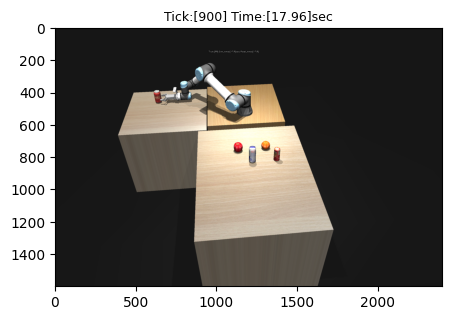

In [191]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=3.5,elevation=-40,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=init_joint_value, joint_idxs=env.idxs_forward)


render_dt = 1./30.
grasping_duration = 2.0
grasping_duration_tick = int(grasping_duration * HZ)

step_gripper(env,'open')
t_s = time.perf_counter()
t_sim_start = t_s

# move to grasping point
ctrl_tick = 0
while ctrl_tick < len(traj_smt)-1:
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        env.step(ctrl=traj_smt[ctrl_tick], ctrl_idxs=env.idxs_step,nstep=int(env.HZ/HZ))
        ctrl_tick += 1
    if time.perf_counter() - t_s >= render_dt:
        p_t = env.get_p_body("ur_base") + [0,-.3,0.6]
        t_s += render_dt
        env.plot_T(p=p_t,R=np.eye(3,3),PLOT_AXIS=False,
                    label="Tick:[%d] Sim_time:[%.1f]sec Real_time:[%.1f]"%(ctrl_tick,env.get_sim_time(),time.perf_counter()-t_sim_start))
        env.plot_contact_info(VERBOSE=True,must_include_prefix=['ur_rg2_gripper_finger1_finger_tip_link','ur_rg2_gripper_finger2_finger_tip_link'])
        env.render()
        
# grasp
ctrl_tick = 0
while ctrl_tick < grasping_duration_tick:
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        step_gripper(env, 'close',nstep=int(env.HZ/HZ))
        ctrl_tick += 1
    if time.perf_counter() - t_s >= render_dt:
        p_t = env.get_p_body("ur_base") + [0,-.3,0.6]
        t_s += render_dt
        env.plot_T(p=p_t,R=np.eye(3,3),PLOT_AXIS=False,
                    label="Tick:[%d] Sim_time:[%.1f]sec Real_time:[%.1f]"%(ctrl_tick,env.get_sim_time(),time.perf_counter()-t_sim_start))
        env.plot_contact_info(VERBOSE=True,must_include_prefix=['ur_rg2_gripper_finger1_finger_tip_link','ur_rg2_gripper_finger2_finger_tip_link'])
        env.render()

# placing
ctrl_tick = 0
while ctrl_tick < len(traj_smt_pl)-1:
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        env.step(ctrl=traj_smt_pl[ctrl_tick], ctrl_idxs=env.idxs_step,nstep=int(env.HZ/HZ))
        ctrl_tick += 1
    if time.perf_counter() - t_s >= render_dt:
        p_t = env.get_p_body("ur_base") + [0,-.3,0.6]
        t_s += render_dt
        env.plot_T(p=p_t,R=np.eye(3,3),PLOT_AXIS=False,
                    label="Tick:[%d] Sim_time:[%.1f]sec Real_time:[%.1f]"%(ctrl_tick,env.get_sim_time(),time.perf_counter()-t_sim_start))
        env.plot_contact_info(VERBOSE=True,must_include_prefix=['ur_rg2_gripper_finger1_finger_tip_link','ur_rg2_gripper_finger2_finger_tip_link'])
        env.render()


# ungrasp
ctrl_tick = 0
while ctrl_tick < grasping_duration_tick:
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        step_gripper(env, 'open',nstep=int(env.HZ/HZ))
        ctrl_tick += 1
    if time.perf_counter() - t_s >= render_dt:
        p_t = env.get_p_body("ur_base") + [0,-.3,0.6]
        t_s += render_dt
        env.plot_T(p=p_t,R=np.eye(3,3),PLOT_AXIS=False,
                    label="Tick:[%d] Sim_time:[%.1f]sec Real_time:[%.1f]"%(ctrl_tick,env.get_sim_time(),time.perf_counter()-t_sim_start))
        env.plot_contact_info(VERBOSE=True,must_include_prefix=['ur_rg2_gripper_finger1_finger_tip_link','ur_rg2_gripper_finger2_finger_tip_link'])
        env.render()

scene_img = env.grab_image()
time.sleep(1)
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
env.close_viewer()
